In this notebook we will be performing data processing before we the data for model traning. Please use the table of contents on the left panel to navigate between sections.

In [ ]:
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


# Load dataset

In [ ]:
# read data

training_data = pd.read_csv('/gdrive/My Drive/Final_Project/final.csv', header=None)

In [ ]:
new_header = training_data.iloc[0] #get the first row to be used as new header
training_data = training_data[1:] 
training_data.columns = new_header #set header

In [ ]:
training_data.head()

,rna,loca
1,GATGACGCTGTAGCTCTCCACGTAATCGACGTGTTCGTCCTGCGGC...,nucleoplasm
2,GATGACGCTGTAGCTCTCCACGTAATCGACGTGTTCGTCCTGCGGC...,nucleolus
3,GATGACGCTGTAGCTCTCCACGTAATCGACGTGTTCGTCCTGCGGC...,chromatin
4,AATTAGCCAGCCCATCCGTCGCTCACGAGGTCGCGCCTCGCACCCG...,nucleoplasm
5,GCACCGGAACGCCGCAGCCGGCGCTCGGTCCATCCGGCCCGTGGGC...,nucleoplasm


In [ ]:
training_data.isna().any()

0
rna     False
loca    False
dtype: bool

^ No missing values.

In [ ]:
training_data.describe()

,rna,loca
count,3950,3950
unique,2049,7
top,GTAAAGGACTGGGGCCCCGCAACTGGCCTCTCCTGCCCTCTTAAGC...,Nucleus
freq,23,1510


The training data contains two columns for a total of 3950 instances with no missing values. The first column contains the RNA sequence, and the second column is the localization of the transcript (7 classes), which will be the label.

# Data Preprocessing

Before we use the data to train our models. We will explore the dataset a little bit to understand its contents.

In [ ]:
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


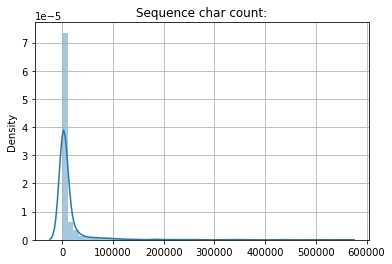

In [ ]:
training_data['sequence length']= training_data['rna'].apply(lambda x: len(x))

def plot_seq_count(df):
  sns.distplot(df['sequence length'].values)
  plt.title(f'Sequence char count:')
  plt.grid(True)

plot_seq_count(training_data)
plt.show()

^ There is a wide distribution of nt (nucleotide) lengths. We decided to fix the length at 4,000 nt. A previous study found out that a sequence length of 4,000 nt was ideal as shorter lengths led reduced performance, and longer length had very little benefits (please see paper for mention of the reference).

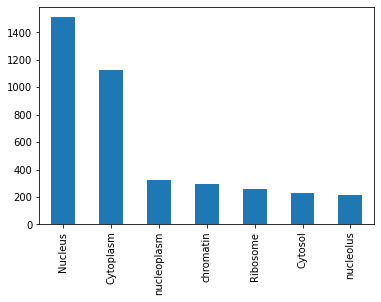

In [ ]:
training_data['loca'].value_counts().plot.bar()

^ The dataset is inbalanced. Most of the RNA sequences belong to the "nucleus" and "cytoplasm" classes. We will balance out the dataset by removing some observations of the majority classes. A drawback is that we're removing information that may be valuable. We will perform random undersampling after *sequence padding*.

## Integer Encoding of Nucleotide Sequences

In [ ]:
nucleotides = ['A', 'C', 'G', 'T']

def create_dict(codes):
  char_dict = {}
  for index, val in enumerate(codes):
    char_dict[val] = index+1

  return char_dict

char_dict = create_dict(nucleotides)

print(char_dict)
print("Dict Length:", len(char_dict))

{'A': 1, 'C': 2, 'G': 3, 'T': 4}
Dict Length: 4


In [ ]:
#Now we will encode our sequences made of letters into sequences of integers
def integer_encoding(data):
  """
  Encodes code sequence to integer values. 
  There're 4 types of nucleotides.
  """
  
  encode_list = []
  for row in data['rna'].values:
    row_encode = []
    for code in row:
      row_encode.append(char_dict.get(code, 0))
    encode_list.append(np.array(row_encode))
  
  return encode_list
  
training_data_encode = integer_encoding(training_data) 

Now the RNA sequences contains integers from 1-4:

In [ ]:
training_data_encode[0]

array([3, 1, 4, ..., 1, 1, 1])

Now encode the labels:

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

training_data_label_encode = le.fit_transform(training_data['loca'])

In [ ]:
le.inverse_transform([0,1,2,3,4,5,6])

array(['Cytoplasm', 'Cytosol', 'Nucleus', 'Ribosome', 'chromatin',
       'nucleolus', 'nucleoplasm'], dtype=object)

## Sequence Padding

Sequences shorter than 4,000 nt are left padded with empty nucelotides. Sequences longer than 4,000 nt are truncated at the 5’ end since a previous study suggested that the localization signals are more often found at the 3′ end (Bergalet and Lécuyer, 2014).

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
training_data_padded = pad_sequences(training_data_encode, padding='pre', truncating='pre', maxlen=4000)

## Random Undersampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler 
# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')
# fit and apply the transform
X_undersampled, y_undersampled = undersample.fit_resample(training_data_padded, training_data_label_encode)

In [ ]:
# we will run the following line again becasue we had two majority classes to be undersampled
X_undersampled, y_undersampled = undersample.fit_resample(X_undersampled, y_undersampled)

In [ ]:
unique, counts = np.unique(y_undersampled, return_counts=True)
dict(zip(unique, counts))

{0: 213, 1: 227, 2: 213, 3: 255, 4: 297, 5: 213, 6: 322}

^ Now every class has a roughly equal amount of observations. In comparison, in our old data, there was a signficantly higher amount of classes 0 and 2:

In [ ]:
unique, counts = np.unique(training_data_label_encode, return_counts=True)
dict(zip(unique, counts))

{0: 1126, 1: 227, 2: 1510, 3: 255, 4: 297, 5: 213, 6: 322}

The downside of this operation is that the number of training instances has been decreased from 3950 to 1740.

## Random Shuffle

In [ ]:
from sklearn.utils import shuffle
training_data_ohe, training_data_label_ohe = shuffle(X_undersampled, y_undersampled)

## Train/Valid/Test Splitting

We will use train_test_split twice to produce a 80/10/10 split on the dataset:

In [ ]:
from sklearn.model_selection import train_test_split
train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

X_train, X_test, y_train, y_test = train_test_split(X_undersampled, y_undersampled, test_size=1 - train_ratio, stratify=y_undersampled)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), stratify=y_test) 

In [ ]:
print(X_train.shape, X_val.shape, X_test.shape)

(1392, 4000) (174, 4000) (174, 4000)


## One Hot Encoding

In [ ]:
from tensorflow.keras.utils import to_categorical
X_train_ohe = [to_categorical(i, num_classes=5) for i in X_train]
X_val_ohe = [to_categorical(i, num_classes=5) for i in X_val]
X_test_ohe = [to_categorical(i, num_classes=5) for i in X_test]

In [ ]:
y_train_ohe = [to_categorical(i, num_classes=7) for i in y_train]
y_val_ohe = [to_categorical(i, num_classes=7) for i in y_val]
y_test_ohe = [to_categorical(i, num_classes=7) for i in y_test]

Convert the lists to numpy arrays:

In [ ]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

X_train_ohe = np.array(X_train_ohe)
X_val_ohe = np.array(X_val_ohe)
X_test_ohe = np.array(X_test_ohe)
y_train_ohe = np.array(y_train_ohe)
y_val_ohe = np.array(y_val_ohe)
y_test_ohe = np.array(y_test_ohe)


In [ ]:
print(X_train.shape, X_val.shape, X_test.shape)

(1392, 4000) (174, 4000) (174, 4000)


## Write Data to File
We will write the numpy arrays to files so that they can used to train models in other notebooks:

In [ ]:
np.save("/gdrive/My Drive/Final_Project/X_train_ohe", X_train_ohe)
np.save("/gdrive/My Drive/Final_Project/X_val_ohe", X_val_ohe)
np.save("/gdrive/My Drive/Final_Project/X_test_ohe", X_test_ohe)
np.save("/gdrive/My Drive/Final_Project/y_train_ohe", y_train_ohe)
np.save("/gdrive/My Drive/Final_Project/y_val_ohe", y_val_ohe)
np.save("/gdrive/My Drive/Final_Project/y_test_ohe", y_test_ohe)

In [ ]:
np.save("/gdrive/My Drive/Final_Project/X_train", X_train)
np.save("/gdrive/My Drive/Final_Project/X_val", X_val)
np.save("/gdrive/My Drive/Final_Project/X_test", X_test)
np.save("/gdrive/My Drive/Final_Project/y_train", y_train)
np.save("/gdrive/My Drive/Final_Project/y_val", y_val)
np.save("/gdrive/My Drive/Final_Project/y_test", y_test)

In [ ]:
# reading the file
#X_train_2=np.load("/gdrive/My Drive/Final/X_train.npy")